In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-traffic-data-with-weather-and-calendar-dataset/traffic_weather_full2020.csv
/kaggle/input/traffic-flow/pems08.npz


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
import random
from torch.cuda.amp import autocast, GradScaler

# Data Preprocessing

In [3]:

plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = 0.5


In [4]:
df=np.load("/kaggle/input/traffic-flow/pems08.npz")
lst=df.files
df[lst[0]].shape

(17856, 170, 3)

In [5]:
traffic_data=df[lst[0]]
data_dict = []
# loop for every timestep and every location and add as a single row
for timestep in range(traffic_data.shape[0]):
    for location in range(traffic_data.shape[1]):
        data_dict.append({
            "timestep" : timestep+1,
            "location" : location,
            "flow"     : traffic_data[timestep][location][0],
            "occupy"   : traffic_data[timestep][location][1],
            "speed"    : traffic_data[timestep][location][2]
        })


In [6]:
d = pd.DataFrame(data_dict)
d.to_csv("traffic.csv", index=False)

print("data is save into traffic.csv")

data is save into traffic.csv


In [7]:
data=pd.read_csv("traffic.csv")
print(len(data))
print(data)

3035520
         timestep  location   flow  occupy  speed
0               1         0  133.0  0.0603   65.8
1               1         1  210.0  0.0589   69.6
2               1         2  124.0  0.0358   65.8
3               1         3  145.0  0.0416   69.6
4               1         4  206.0  0.0493   69.4
...           ...       ...    ...     ...    ...
1499995      8824        85  181.0  0.0618   67.5
1499996      8824        86  351.0  0.0727   63.4
1499997      8824        87  183.0  0.0613   63.5
1499998      8824        88  218.0  0.0702   61.2
1499999      8824        89  190.0  0.0658   63.1

[1500000 rows x 5 columns]


# Scaling

In [8]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()
data[['flow']] = scaler.fit_transform(data[['flow']])

raw_traffic = data["flow"].values.astype(np.float32)

data_no_smooth = torch.tensor(raw_traffic)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
numeric_data = data.select_dtypes(include=np.number)
numeric_data_tensor = torch.tensor(numeric_data.values, dtype=torch.float32)
numeric_data

,timestep,location,flow,occupy,speed
0,1,0,-0.658668,0.0603,65.8
1,1,1,-0.128752,0.0589,69.6
2,1,2,-0.720606,0.0358,65.8
3,1,3,-0.576083,0.0416,69.6
4,1,4,-0.156280,0.0493,69.4
...,...,...,...,...,...
1499995,8824,85,-0.328330,0.0618,67.5
1499996,8824,86,0.841613,0.0727,63.4
1499997,8824,87,-0.314566,0.0613,63.5
1499998,8824,88,-0.073696,0.0702,61.2


In [11]:
def apply_simple_moving_average(data, steps_per_day=4):
    data=torch.Tensor(data)
    smoothed_data = data.clone()
    for i in range(steps_per_day, len(data)):
        if i>4:
            smoothed_data[i] = torch.mean(data[i-steps_per_day:i])#eq 19
    return smoothed_data

def apply_weighted_moving_average(data, steps_per_day=4):
    data=torch.Tensor(data)
    smoothed_data=data.clone()
    weights=torch.tensor([4,3,2,1],dtype=torch.float32)/10.0 
    for i in range(steps_per_day,len(data)):
        if(i>4):
            data_slice=data[i-steps_per_day:i]  
            smoothed_data[i]=torch.sum(weights.view(-1,1)*data_slice)#eq 20

    return smoothed_data


In [12]:
def noisy_idx(data,avg,A):
    """Returns idx of noisy data"""
    if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series):
        data_tensor = torch.tensor(data.values, dtype=torch.float32)
    else:
        data_tensor = data
    
    avg_tensor = avg  
    
    noisy_index=torch.nonzero(torch.abs(avg_tensor-data_tensor)>A,as_tuple=True)[0].tolist()#eq1
    return noisy_index



In [13]:
def smooth_noisy_data(data, avg, noisy_index):
    smooth_data = data.clone()#avg=historical average

    if not noisy_index:
        return smooth_data

    num_noisy = len(noisy_index)

    if num_noisy > 0:
        first_noisy=noisy_index[0]
        if first_noisy>=2:
            smooth_data[first_noisy]=2*(data[first_noisy-1]-avg[first_noisy-1])-(data[first_noisy-2]-avg[first_noisy-2])#eq2

    if num_noisy > 1:
        last_noisy=noisy_index[-1]
        if last_noisy+2<len(data):
            smooth_data[last_noisy]=2*(data[last_noisy+1]-avg[last_noisy+1])-(data[last_noisy+2]-avg[last_noisy+2])#eq3

    l=1
    r=num_noisy-2
    while l<=r:
        t=noisy_index[l]
        if t>=2:
            smooth_data[t]=2*(smooth_data[t-1]-avg[t-1])-(data[t-2]-avg[t-2])+avg[t]
        l+=1

        if l>r:
            break

        t=noisy_index[r]
        if t+2<len(data):
            smooth_data[t]=2*(smooth_data[t+1]-avg[t+1])-(data[t+2]-avg[t+2])+avg[t]
        r-=1

    if num_noisy % 2 == 1:
        mid=noisy_index[(num_noisy -1)// 2]
        before_idx=mid-1
        after_idx=mid+1
        if 0<=before_idx<len(data) and 0<=after_idx<len(data):
            smooth_data[mid] = (smooth_data[before_idx] + smooth_data[after_idx]) / 2 + avg[mid]#eq4

    return smooth_data


In [14]:

class HistoricalAttention(nn.Module):
    def __init__(self, num_days):
        super(HistoricalAttention, self).__init__()
        self.linear = nn.Linear(num_days, num_days, bias=True)
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        logits = self.linear(x)
        alpha = F.softmax(logits, dim=1)
        weighted_sum = torch.bmm(alpha.unsqueeze(1), x.unsqueeze(-1)).squeeze(-1)
        return weighted_sum + self.bias


In [15]:
class LSTMCell(nn.Module):
    """Modified LSTMCell with dropout."""
    def __init__(self,input_size,hidden_units,hist_data=1,dropout_prob=0.2):
        super(LSTMCell, self).__init__()
        self.hidden_units=hidden_units
        self.dropout=nn.Dropout(dropout_prob)

        combined=input_size+hidden_units+hist_data

        self.input_gate=nn.Linear(combined, hidden_units)#eq 7
        self.forget_gate=nn.Linear(combined, hidden_units)#eq 9
        self.output_gate=nn.Linear(combined, hidden_units)#eq 11
        self.cell_gate=nn.Linear(combined, hidden_units)#eq 13

    def forward(self, x, hidden_units, cell, hist_data):
        """
        x: current state,
        hidden_units: previous hidden state
        cell: previous cell state (lstm memory)
        hist_data: external historical data input
        """
        combined=torch.cat([x, hidden_units, hist_data], dim=1)

        input_gate=torch.sigmoid(self.input_gate(combined))#eq 8
        forget_gate=torch.sigmoid(self.forget_gate(combined))#eq 10
        output_gate=torch.sigmoid(self.output_gate(combined))#eq 14
        cell_update=torch.tanh(self.cell_gate(combined))

        new_cell = forget_gate * cell + input_gate * cell_update #eq 12
        new_hidden = output_gate * torch.tanh(new_cell)#eq 15

        #droupout-handles overfitting by making some neuron to 0
        new_hidden = self.dropout(new_hidden)  

        return new_hidden, new_cell


In [16]:
# seq len-Represents the length of the current time-series sequence being processed.
# num_days -(Historical Data)Represents the number of past days (or time steps) considered for historical context.

In [17]:
# We chose only the data near the predicted time of each cycle to reduce redundant input data

In [18]:
class LSTMplus(nn.Module):
    def __init__(self,input_size,hidden_units,num_days,dropout_prob=0.1):
        super(LSTMplus,self).__init__()

        self.hidden_units=hidden_units
        self.num_days=num_days
        self.hist_attention = HistoricalAttention(num_days)
        self.lstm_cell=LSTMCell(input_size,hidden_units,hist_data=1,dropout_prob=dropout_prob)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self,curr_seq,hist_data):
        """
        curr_seq shape: (batch_size, seq_len, input_size)
        hist_data shape: (batch_size, num_days)
        """
        data=self.hist_attention(hist_data)

        batch_size=curr_seq.size(0)
        
        for t in range(curr_seq.size(1)):
            x_t=curr_seq[:, t, :]
            
            if t==0:
                h=torch.zeros(batch_size,self.hidden_units,device=curr_seq.device)
                c=torch.zeros(batch_size,self.hidden_units,device=curr_seq.device)

            h,c=self.lstm_cell(x_t,h,c,data)

        h=self.dropout(h)  

        return self.fc(h)


In [19]:
# h (hidden state) and c (cell state) decide which past data is important and
# how much of it should be carried forward at each time step


# Experiments

In [20]:
class Traffic_DataSet(Dataset):
    def __init__(self, data_1d, seq_len, num_days, day_period):
        super().__init__()
        self.data=data_1d
        self.seq_len=seq_len
        self.num_days=num_days
        self.day_period=day_period
        
        self.start_index = max(seq_len,num_days*day_period)
        self.end_index=len(data_1d)-1

    def __len__(self):
        return self.end_index-self.start_index

    def __getitem__(self, idx):
        t = self.start_index+idx
        curr_seq = self.data[t-self.seq_len:t]  
        # curr_seq=torch.tensor(curr_seq,dtype=torch.float32).unsqueeze(-1)
        curr_seq=curr_seq.clone().detach().unsqueeze(-1)
        
        historical=[]
        for d in range(1,self.num_days+1):
            day_t=t-d*self.day_period
            historical.append(self.data[day_t])

        hist_seq=torch.tensor(historical,dtype=torch.float32)

        # target = torch.tensor(self.data[t], dtype=torch.float32).view(1)
        target=self.data[t].clone().detach().view(1)
        
        return curr_seq,hist_seq,target


In [21]:
#If we have hourly traffic data and want to:

#Use the last 10 hours (seq_len=10) as short-term history.
#Use past 7 days (num_days=7) at the same hour (day_period=24).
#Then, for a given t, the sample will contain:

#curr_seq: The last 10 hourly values before t.
#hist_seq: The traffic data at the same hour on the last 7 days.
#target: The traffic value at t

# Input


In [22]:
from torch.optim import Adam

learning_rate=0.0001
batch_size=32
seq_len=10
num_days=7
hidden_units=64
num_epochs=30
day_period=288

model=LSTMplus(input_size=1,hidden_units=hidden_units,num_days=num_days).to(device)

model1=LSTMplus(input_size=1,hidden_units=hidden_units,num_days=num_days).to(device)
# optimizer=Adam(model.parameters(),lr=learning_rate)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [23]:
model

LSTMplus(
  (hist_attention): HistoricalAttention(
    (linear): Linear(in_features=7, out_features=7, bias=True)
  )
  (lstm_cell): LSTMCell(
    (dropout): Dropout(p=0.1, inplace=False)
    (input_gate): Linear(in_features=66, out_features=64, bias=True)
    (forget_gate): Linear(in_features=66, out_features=64, bias=True)
    (output_gate): Linear(in_features=66, out_features=64, bias=True)
    (cell_gate): Linear(in_features=66, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [24]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for curr_seq, hist_data, target in dataloader:
        curr_seq, hist_data, target = curr_seq.to(device), hist_data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(curr_seq, hist_data)
        loss = criterion(output, target.view(-1,1))

        loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() 

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    return avg_loss


In [25]:
def evaluate(y_true, y_pred, scaler_y):
    y_pred = y_pred.reshape(-1, 1)
    y_true = y_true.reshape(-1, 1)

    y_pred_original = scaler_y.inverse_transform(y_pred)
    y_true_original = scaler_y.inverse_transform(y_true)


    mae = np.mean(np.abs(y_true_original - y_pred_original))

    epsilon = np.percentile(np.abs(y_true_original), 5) 
    epsilon = max(epsilon, 1e-6) 

    mre = np.mean(np.abs(y_true_original - y_pred_original) / (np.abs(y_true_original) + epsilon)) * 100
    rmse = np.sqrt(np.mean((y_true_original - y_pred_original) ** 2))

    return mae, mre, rmse


In [26]:
def test(model, dataloader, device, scaler):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for curr_seq, hist_data, target in dataloader:
            curr_seq, hist_data, target = curr_seq.to(device), hist_data.to(device), target.to(device)
            output = model(curr_seq, hist_data)

            predictions.append(output.cpu().numpy())
            actuals.append(target.cpu().numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    mae, mre, rmse = evaluate(actuals, predictions, scaler)

    return mae, mre, rmse


In [27]:
model = torch.compile(model)


# Experiment

In [28]:

data_no_smooth=torch.tensor(raw_traffic)

avg_=data_no_smooth.clone()  

noisy_index=noisy_idx(data_no_smooth,avg_,A=150) 

smoothed_data=smooth_noisy_data(data_no_smooth,avg_,noisy_index)

print("data preprocessing complete")


data preprocessing complete


In [29]:

dataset = Traffic_DataSet(
        data_1d=smoothed_data, 
        seq_len=seq_len, 
        num_days=num_days, 
        day_period=day_period
    )
n_total=len(dataset)
n_train=int(0.8*n_total)
n_val=n_total-n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))

train_dataloader=DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dataloader=DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Trainning And Visualize

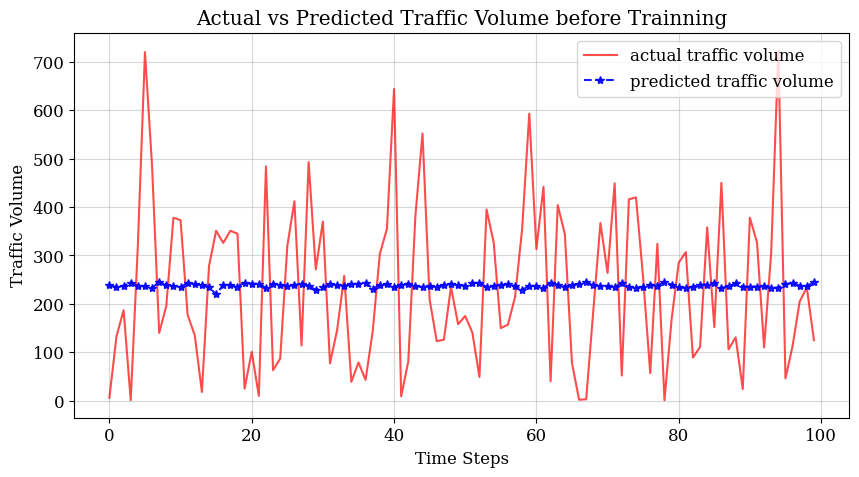

In [30]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for curr_seq, hist_data, target in test_dataloader:
        curr_seq, hist_data, target = curr_seq.to(device), hist_data.to(device), target.to(device)
        output = model1(curr_seq, hist_data)
        
        y_pred.append(output.cpu().numpy())
        y_true.append(target.cpu().numpy())


y_pred = np.concatenate(y_pred).flatten()
y_true = np.concatenate(y_true).flatten()

y_true_original=scaler.inverse_transform(y_true.reshape(-1,1)).flatten()
y_pred_original=scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()

plt.figure(figsize=(10, 5))
plt.plot(y_true_original[:100], label="actual traffic volume", linestyle='-', alpha=0.7, color='red')
plt.plot(y_pred_original[:100], label="predicted traffic volume", marker='*', linestyle='--', alpha=.9, color='blue')
plt.title("Actual vs Predicted Traffic Volume before Trainning")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


In [31]:

variants={"pLSTM":smoothed_data}

day_period = 288
criterion = nn.MSELoss()
# criterion= torch.nn.L1Loss()
result = {}

for approach_name, traffic_1d in variants.items():
    print("Trainning Started.............")
    dataset = Traffic_DataSet(
        data_1d=traffic_1d, 
        seq_len=seq_len, 
        num_days=num_days, 
        day_period=day_period
    )
    n_total = len(dataset)
    n_train = int(0.8 * n_total)
    n_val = n_total - n_train
    train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))


    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, 
                              num_workers=2, pin_memory=True)
    test_loader = DataLoader(val_ds, batch_size=32, shuffle=False, 
                                 num_workers=2, pin_memory=True)

    model = LSTMplus(
        input_size=1,
        hidden_units=hidden_units,
        num_days=num_days
    ).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.00001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    mae_list = []
    mre_list = []
    rmse_list = []
    train_loss_list = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        
        mae, mre, rmse = test(model, test_loader, device, scaler) 
        
        train_loss_list.append(train_loss)
        mae_list.append(mae)
        mre_list.append(mre)
        rmse_list.append(rmse)
        print(f"[{approach_name}] Epoch {epoch+1}/{num_epochs} => "
              f"Train Loss={train_loss:.4f}, Val MAE={mae:.4f}, "
              f"MRE={mre:.2f}%, RMSE={rmse:.4f}",flush=True)
        scheduler.step() 
    
    result[approach_name] = {
        "train_loss" :train_loss_list,
        "mae": mae_list,
        "mre": mre_list,
        "rmse": rmse_list
    }
    print("-------------------------------------------------------------",flush=True)


Trainning Started.............
[pLSTM] Epoch 1/30 => Train Loss=0.5531, Val MAE=77.3652, MRE=49.33%, RMSE=102.6609
[pLSTM] Epoch 2/30 => Train Loss=0.4308, Val MAE=62.0904, MRE=39.29%, RMSE=82.6489
[pLSTM] Epoch 3/30 => Train Loss=0.3206, Val MAE=53.2018, MRE=33.01%, RMSE=72.2405
[pLSTM] Epoch 4/30 => Train Loss=0.2712, Val MAE=48.4715, MRE=29.81%, RMSE=66.7849
[pLSTM] Epoch 5/30 => Train Loss=0.2439, Val MAE=45.6481, MRE=27.74%, RMSE=63.3450
[pLSTM] Epoch 6/30 => Train Loss=0.2295, Val MAE=44.2081, MRE=26.67%, RMSE=61.6965
[pLSTM] Epoch 7/30 => Train Loss=0.2225, Val MAE=43.3397, MRE=26.40%, RMSE=60.4995
[pLSTM] Epoch 8/30 => Train Loss=0.2161, Val MAE=42.3959, MRE=25.53%, RMSE=59.4314
[pLSTM] Epoch 9/30 => Train Loss=0.2108, Val MAE=41.5716, MRE=25.01%, RMSE=58.5179
[pLSTM] Epoch 10/30 => Train Loss=0.2057, Val MAE=40.9027, MRE=24.40%, RMSE=57.7121
[pLSTM] Epoch 11/30 => Train Loss=0.2022, Val MAE=40.4867, MRE=24.21%, RMSE=57.2270
[pLSTM] Epoch 12/30 => Train Loss=0.2004, Val MAE=40.

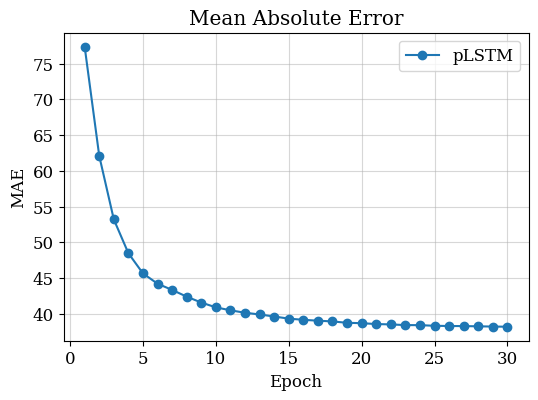

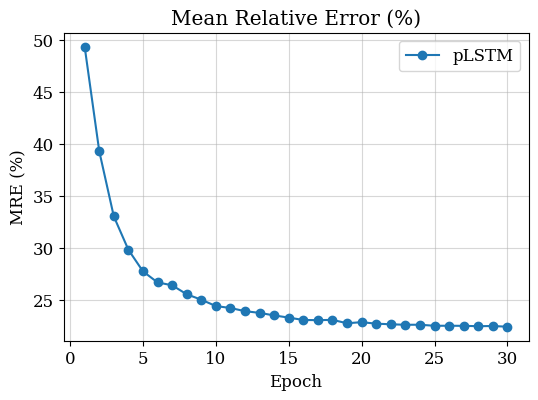

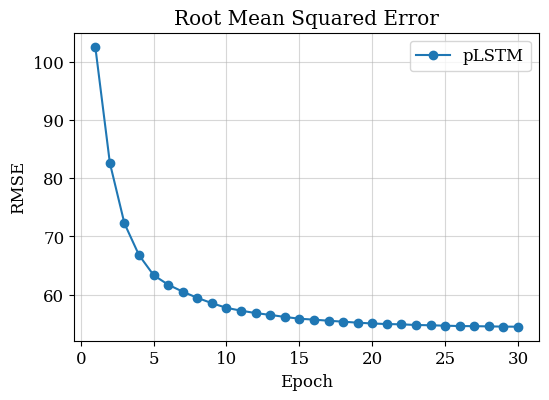

In [32]:

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(6, 4))
for approach_name, metric_dict in result.items():
    plt.plot(epochs, metric_dict["mae"], marker='o', label=approach_name)
plt.title("Mean Absolute Error")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
for approach_name, metric_dict in result.items():
    plt.plot(epochs, metric_dict["mre"], marker='o', label=approach_name)
plt.title("Mean Relative Error (%)")
plt.xlabel("Epoch")
plt.ylabel("MRE (%)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(6, 4))
for approach_name, metric_dict in result.items():
    plt.plot(epochs, metric_dict["rmse"], marker='o', label=approach_name)
plt.title("Root Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


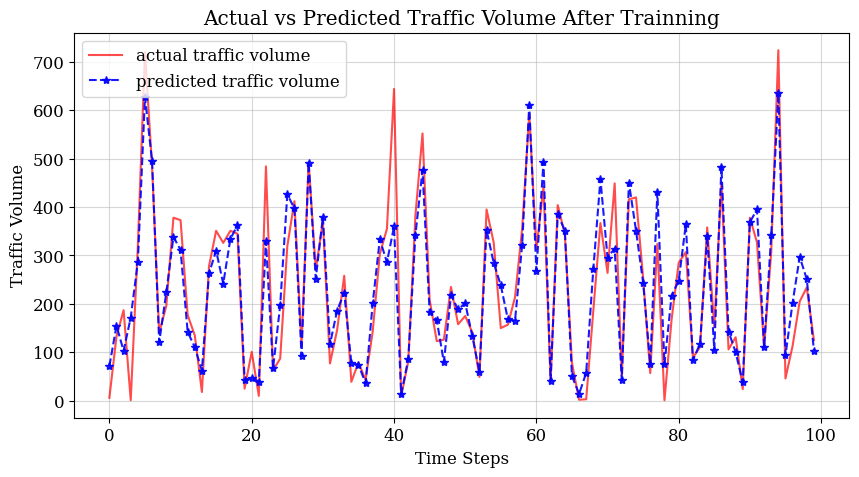

In [36]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for curr_seq, hist_data, target in test_dataloader:
        curr_seq, hist_data, target = curr_seq.to(device), hist_data.to(device), target.to(device)
        output = model(curr_seq, hist_data)
        
        y_pred.append(output.cpu().numpy())
        y_true.append(target.cpu().numpy())


y_pred = np.concatenate(y_pred).flatten()
y_true = np.concatenate(y_true).flatten()

y_true_original=scaler.inverse_transform(y_true.reshape(-1,1)).flatten()
y_pred_original=scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()

plt.figure(figsize=(10, 5))
plt.plot(y_true_original[:100], label="actual traffic volume", linestyle='-', alpha=0.7, color='red')
plt.plot(y_pred_original[:100], label="predicted traffic volume", marker='*', linestyle='--', alpha=.9, color='blue')
plt.title("Actual vs Predicted Traffic Volume After Trainning")
plt.xlabel("Time Steps")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()
